In [1]:
import scanpy as sc
import decoupler as dc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
tissue_dict = {
    'Adrenal': '#8B4513',        
    'CortexHippocampus': '#F8C471',
    'DiencephalonPituitary': '#27AE60',  
    'Gastrocnemius': '#FF69B4',        
    'GonadsFemale': '#2FE3E5',       
    'GonadsMale': '#00B7B8',
    'Heart': '#AF7AC5',       
    'Kidney': '#CF1E1A',        
    'Liver': '#F15922',            
}

sex_dict = {
    'Female': 'hotpink',
    'Male': 'dodgerblue',  
    
}

geno_dict = {
    '129S1J': '#DA9CC1',  
    'AJ': '#F4C245',             
    'B6J': '#C0BFBF',               
    'CASTJ': '#55AF5B',  
    'NODJ': '#4F6EAF',        
    'NZOJ': '#52A5DB',              
    'PWKJ': '#D83026',        
    'WSBJ': '#683C91'   
}

type_dict = {
    "Antigen-presenting cells": "#1f78b4",  
    "B cells": "#a6cee3", 
    "Dendritic cells": "#ff7f00", 
    "Kupffer cells": "#fdbf6f",  
    "Macrophages": "#33a02c", 
    "Microglia": "#b2df8a",  
    "Monocytes": "#e31a1c",
    "NK cells": "#fb9a99", 
    "Proliferating cells": "#6a3d9a", 
    "T cells": "#cab2d6"  
}

state_dict = {
    "Active": "#1f78b4",
    "Antigen_Presenting": "#a6cee3",
    "Antiviral": "#ff7f00",
    "Cytotoxic": "#fdbf6f",
    "Homeostasis": "#33a02c",
    "Inflamed": "#b2df8a",
    "M1": "#e31a1c",
    "M2":"#fb9a99",
    "Migratory": "#6a3d9a",
    "Mitotic": "#cab2d6",
    "Naive": "#8b574b",
    "Tissue repair": "#c49b94",
    "Tissue_Remodeling": "#df78c2",
    "cDC1": "#f9b6d2",
    "cDC2": "#808080",
    "pDCs": "#c8c8c8",
}




In [3]:
def stacked_barplot_proportions(adata, cluster_key, var_key, fsize=(12, 6), annotations=True, reverse_order=False, custom_order=None, custom_colors=None, remove_y_labels = False, save_path=None):
    colors = sns.color_palette("husl", n_colors=len(adata[var_key].unique()))

    # Group the data by 'cluster_key' and 'var_key', count occurrences, and calculate proportions
    grouped_data = adata.groupby([cluster_key, var_key]).size().unstack().fillna(0)
    proportions = grouped_data.div(grouped_data.sum(axis=1), axis=0)

    # Apply custom order if provided
    if custom_order:
        proportions = proportions.loc[custom_order]
        
        # Recalculate 'm' with Genotype counts based on custom_order
        m = adata.groupby(cluster_key).size().to_frame()
        m = m.reset_index()
        m[cluster_key] = pd.Categorical(m[cluster_key], categories=custom_order, ordered=True)
        m = m.sort_values(cluster_key).reset_index(drop=True)
        m = m.set_index(cluster_key)

    if custom_colors:
        colors = custom_colors

    # Reverse the order of the DataFrame if reverse_order is True
    if reverse_order:
        proportions = proportions.iloc[::-1]
        m = m.iloc[::-1]

    # Create the stacked bar plot
    ax = proportions.plot(kind='barh', color=colors, stacked=True, figsize=fsize, width=0.8, edgecolor=None)

    # Remove the plot outline (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    if annotations:
        for i, txt in enumerate(m[0]):
            # Annotate using the sorted m DataFrame
            ax.text(0.875, i, f'{txt}', fontsize=15, va='center', transform=ax.get_yaxis_transform())

    plt.xlim(0, 1.15)
    
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=18)
    ax.set_xlabel("Proportion", fontsize=18)
    ax.set_title(f'{var_key}', fontsize=20)
    ax.set_ylabel(f'{cluster_key}', fontsize=18) # remove title
    
    ax.get_legend().remove()

    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    
    if remove_y_labels:
        ax.set_ylabel('', fontsize=18) # remove title
        ax.tick_params(axis="y", left=False) # remove ticks
        ax.set_yticklabels([]) # remove y tick labels

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


In [4]:
adata = sc.read_h5ad('/share/crsp/lab/seyedam/share/ER_EA/8cube_immunecells/annotated_data_17_36.h5ad')
adata.obs['state'] = adata.obs['state'].replace('Tissue-Remodeling', 'Tissue_Remodeling')


In [5]:
adata = adata[adata.obs['Genotype'] != 'TREM2R47HNSS_HO']


In [6]:
genotype_categories = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']
tissue_categories = ['CortexHippocampus',
                     'DiencephalonPituitary',
                     'Heart',
                     'GonadsFemale',
                     'Adrenal',
                     'Gastrocnemius',
                     'Kidney',
                     'Liver',
                     'GonadsMale',
                     ]
sex_categories = ['Female', 'Male']

cluster_order = [13, 18, 30, 20, 21, 35, 32,
                12, 2, 24, 10, 7, 0, 9, 14, 
                19, 31, 16, 25, 26, 4, 23, 17, 
                33, 11, 1, 22, 3, 8, 27, 34, 
                28, 6, 29, 5, 15]

adata.obs['Genotype'] = pd.Categorical(adata.obs['Genotype'], categories=genotype_categories, ordered=True)
adata.obs['Tissue'] = pd.Categorical(adata.obs['Tissue'], categories=tissue_categories, ordered=True)
adata.obs['Sex'] = pd.Categorical(adata.obs['Sex'], categories=sex_categories, ordered=True)
adata.obs['leiden'] = pd.Categorical(adata.obs['leiden'], categories=cluster_order, ordered=True)


/tmp/ipykernel_2590386/4238826736.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Genotype'] = pd.Categorical(adata.obs['Genotype'], categories=genotype_categories, ordered=True)
/opt/apps/python/3.8.0/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


# Fig. 3a

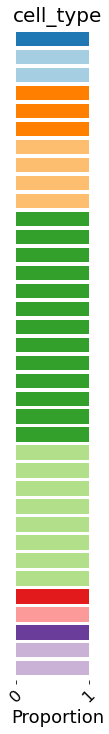

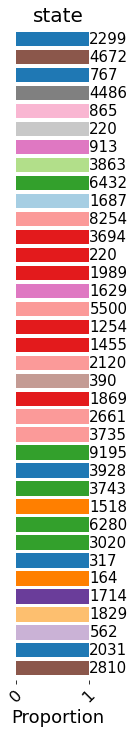

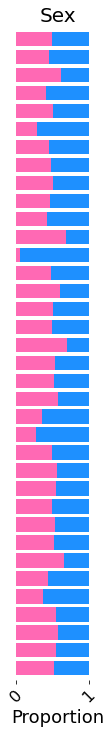

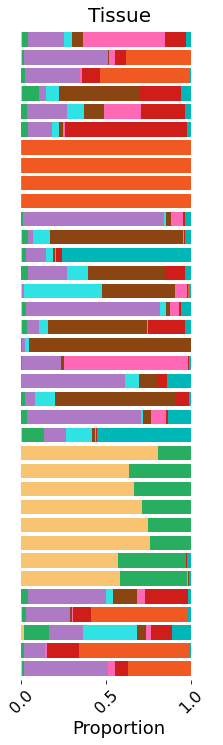

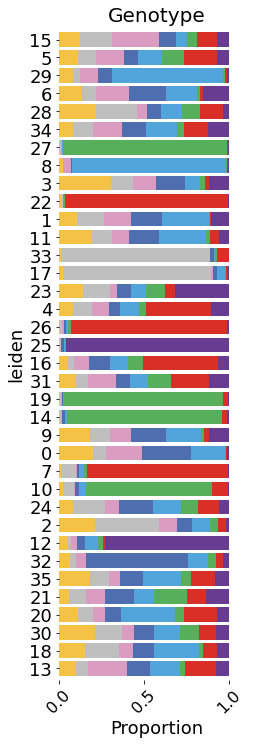

In [7]:
stacked_barplot_proportions(adata.obs, 
                            'leiden', 'cell_type',
                            reverse_order=False,
                            fsize=(1.5, 12),  
                            annotations=False,
                            custom_order =cluster_order,
                            custom_colors = type_dict,
                            remove_y_labels = True,
                            save_path = '../fig3/cluster_celltype_barplot.png'
                           )

stacked_barplot_proportions(adata.obs, 
                            'leiden', 'state',
                            reverse_order=False,
                            fsize=(1.5, 12),  
                            annotations=True,
                            custom_order = cluster_order,
                            custom_colors = state_dict,
                            remove_y_labels = True,
                            save_path = '../fig3/cluster_state_barplot.png'
                           )


stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Sex',
                            reverse_order=False,
                            fsize=(1.5, 12),  
                            annotations=False,
                            custom_order = cluster_order,
                            custom_colors = sex_dict,
                            remove_y_labels = True,
                            save_path = '../fig3/cluster_sex_barplot.png'
                           )

stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Tissue',
                            reverse_order=False,
                            fsize=(3.5, 12),  
                            annotations=False,
                            custom_order = cluster_order,
                            custom_colors = tissue_dict,
                            remove_y_labels = True,
                            save_path = '../fig3/cluster_tissue_barplot.png'
                           )

stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Genotype',
                            reverse_order=False,
                            fsize=(3.5, 12),  
                            annotations=False,
                            custom_order = cluster_order,
                            custom_colors = geno_dict,
                            remove_y_labels = False,
                            save_path = '../fig3/cluster_geno_barplot.png'
                           )


# Fig. 3b


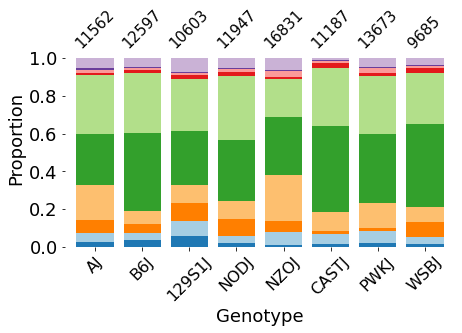

In [41]:
grouped_data = adata.obs.groupby(['Genotype', 'cell_type']).size().unstack().fillna(0)
proportions = grouped_data.div(grouped_data.sum(axis=1), axis=0)

proportions = proportions.loc[genotype_categories]

m = adata.obs.groupby(['Genotype']).size().to_frame()
m = m.reset_index()
m['Genotype'] = pd.Categorical(m['Genotype'], categories=genotype_categories, ordered=True)
m = m.sort_values('Genotype').reset_index(drop=True)
m = m.set_index('Genotype')

ax = proportions.plot(kind='bar', color=type_dict, stacked=True, figsize=(7, 4), width=0.8, edgecolor=None)

# Remove the plot outline (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

for i, txt in enumerate(m[0]):
    ax.text(i, 0.9, f'{txt}', fontsize=15, rotation = 45,ha='center', 
            va='bottom', transform=ax.get_xaxis_transform())  # Adjust for vertical orientation

plt.ylim(0, 1.15)

ax.tick_params(axis="x", labelsize=16, rotation=45)  # Rotate x-axis labels
ax.tick_params(axis="y", labelsize=18)
ax.set_ylabel("Proportion", fontsize=18)  # Y-axis is now proportion
ax.set_xlabel('Genotype', fontsize=18)   # X-axis is now the cluster_key
ax.set_title('')

ax.get_legend().remove()

plt.savefig('../fig3/immune_celltype_barplot.png', dpi=300, bbox_inches='tight')



# Fig. 3c

In [50]:
def plot_gene(dpadata, gene, celltype):
    dpadata_sub = dpadata[dpadata.obs['cell_type'] == celltype]
    plt.figure(figsize=(6, 3.75))
    pb_df = sc.get.obs_df(dpadata_sub, ['Genotype','Sex',gene])
    genotype_categories = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']
    sns.violinplot(data=pb_df, x='Genotype', y=gene, inner=None, cut=0, scale='width', order=genotype_categories,
                   palette=geno_dict, legend=None)

    sns.stripplot(data=pb_df, x='Genotype', y=gene, hue = 'Sex',
                  palette = sex_dict,
                  size=6, jitter=True,  
                  edgecolor='black', linewidth=1,
                  order=genotype_categories, legend=None)


    plt.title(f'{gene}', fontsize=28)
    plt.xlabel('')
    plt.ylabel(f'{gene} Expression\n(RPM)', fontsize=22)
    
    plt.xticks(fontsize=22,rotation = 45, ha = 'right')
    plt.yticks(fontsize=22)
    plt.ylim(bottom=0)
    plt.grid(axis='y',  linewidth=0.5)
    plt.savefig(f"../fig3/genotype_violin_{celltype}_{gene}.png",bbox_inches='tight', dpi=300)
    plt.show()

In [20]:
pbdata = dc.get_pseudobulk(
    adata,
    sample_col="lab_sample_id",
    groups_col="cell_type",
    layer = 'cellbender_counts',
    mode='sum',
    skip_checks=True,
    min_cells=10,
    min_counts=1000
)

sc.pp.normalize_total(pbdata, target_sum=1e6)


In [21]:
genes_of_interest = ['Ifi202b', 'Gbp2b','BC018473','H2-Ea']


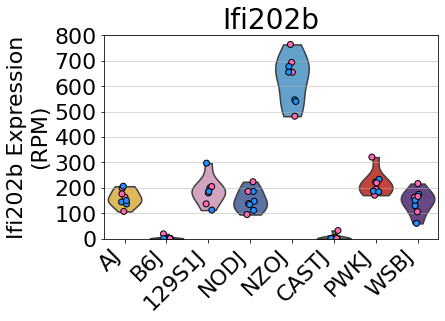

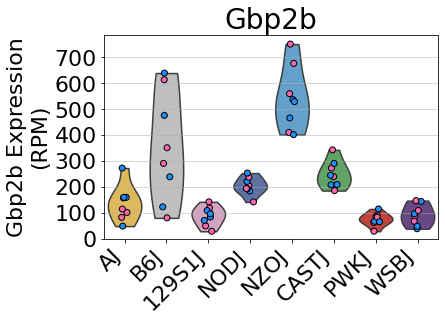

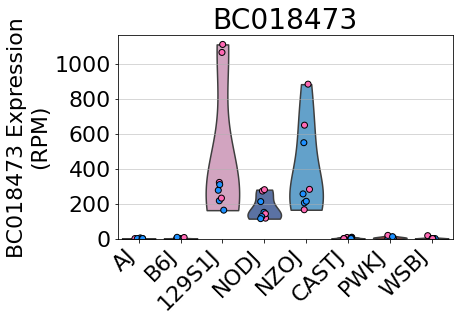

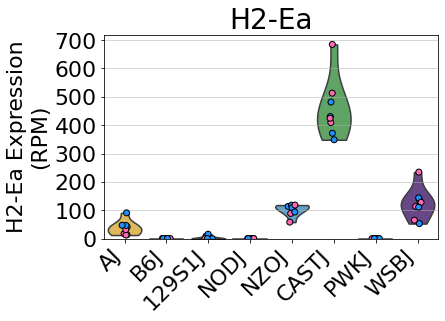

In [51]:
for gene in genes_of_interest:
    plot_gene(pbdata, gene, 'Kupffer cells')
    

# Fig. 3d

In [55]:
def plot_gene_color_tissue(dpadata, gene, celltype):
    dpadata_sub = dpadata[dpadata.obs['cell_type'] == celltype]
    plt.figure(figsize=(6, 3.75))
    pb_df = sc.get.obs_df(dpadata_sub, ['Genotype','Tissue',gene])
    genotype_categories = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']
    sns.violinplot(data=pb_df, x='Genotype', y=gene, inner=None, cut=0, scale='width', order=genotype_categories,
                   palette=geno_dict, legend=None)

    sns.stripplot(data=pb_df, x='Genotype', y=gene, hue = 'Tissue',
                  palette = tissue_dict,
                  size=6, jitter=True,  
                  edgecolor='black', linewidth=1,
                  order=genotype_categories, legend=None)


    plt.title(f'{gene}', fontsize=28)
    plt.xlabel('')
    plt.ylabel(f'{gene} Expression\n(RPM)', fontsize=22)
    
    plt.xticks(fontsize=22,rotation = 45, ha = 'right')
    plt.yticks(fontsize=22)
    plt.ylim(bottom=0)
    plt.grid(axis='y',  linewidth=0.5)
    plt.savefig(f"../fig3/genotype_violin_{celltype}_{gene}.png",bbox_inches='tight', dpi=300)
    plt.show()

In [57]:
genes_of_interest = ['Ebf3', 'Ets1','Msh5','Il7r']


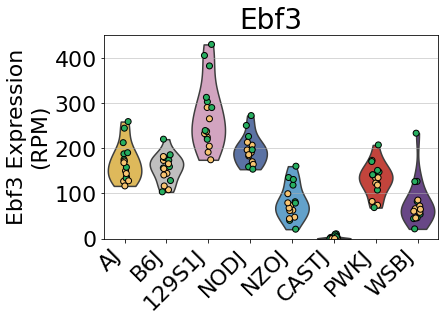

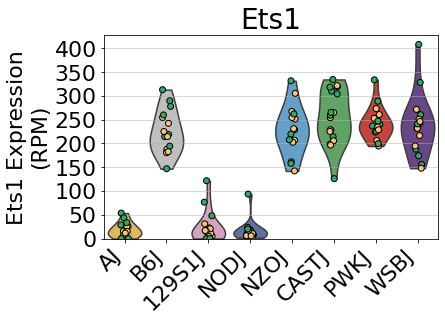

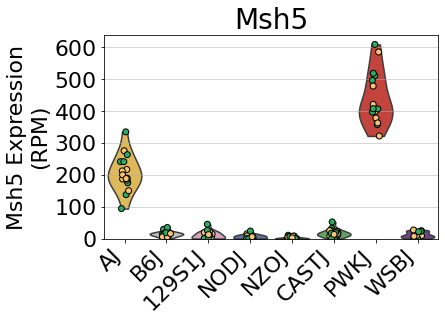

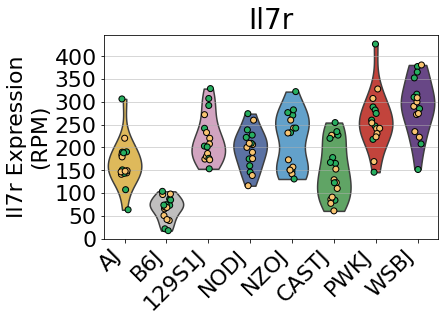

In [58]:
for gene in genes_of_interest:
    plot_gene_color_tissue(pbdata, gene, 'Microglia')
    

# Legends

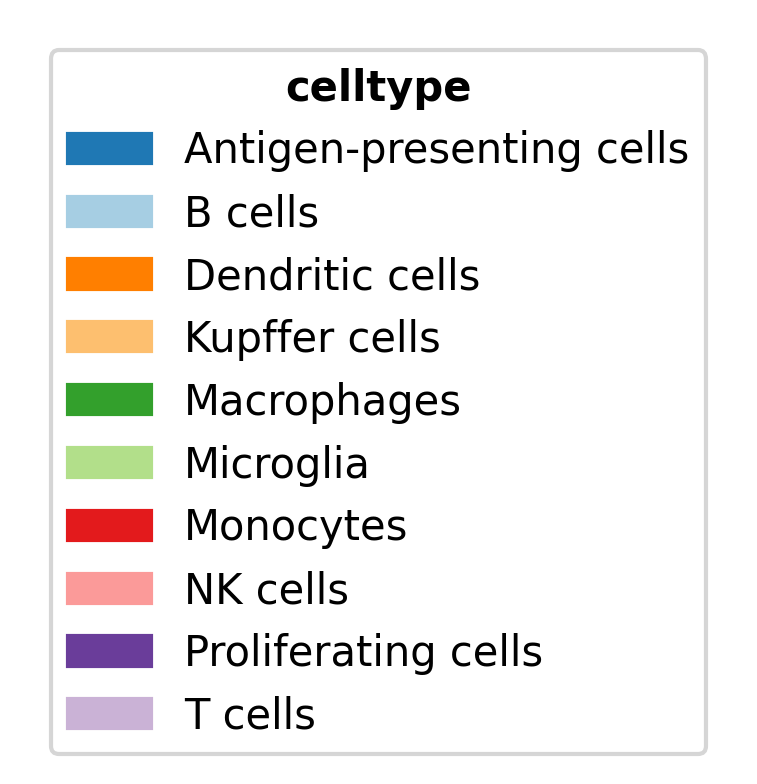

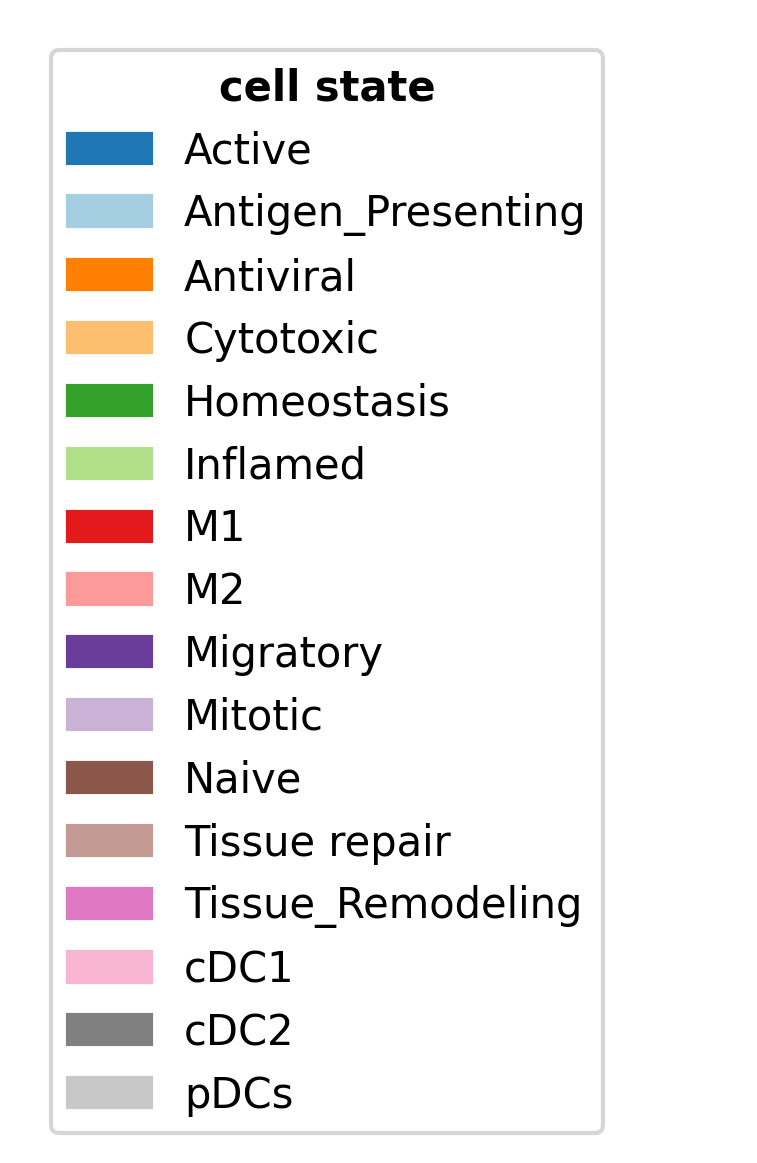

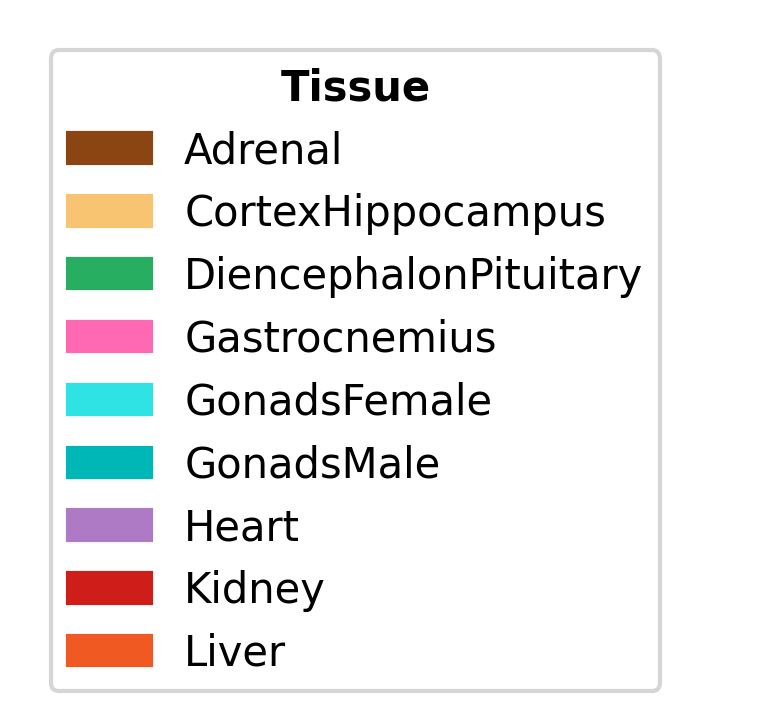

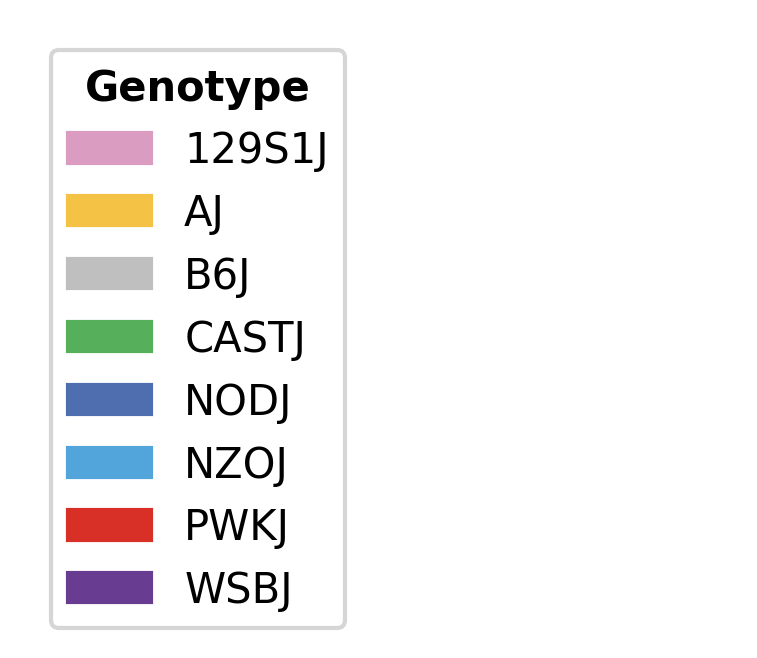

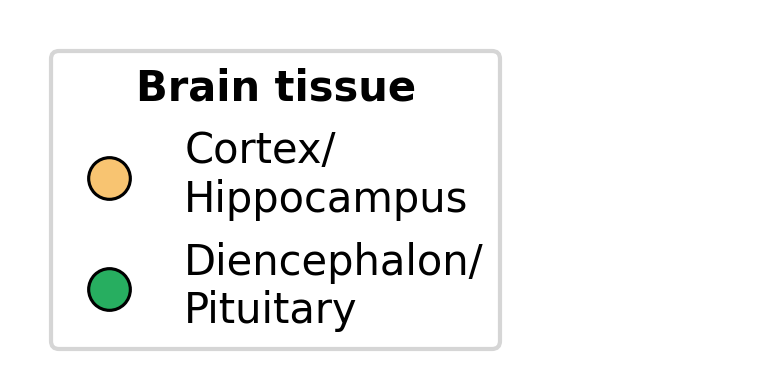

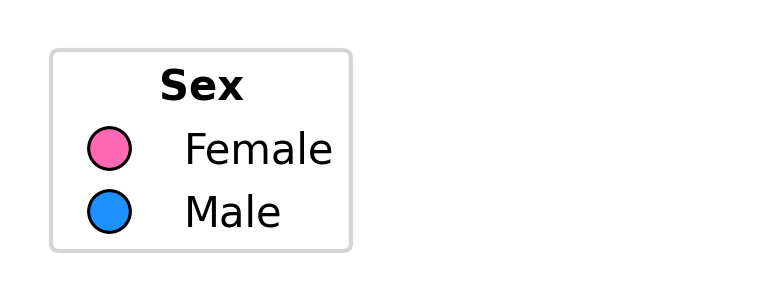

In [62]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def create_standalone_legend(color_dict, label, order, location='upper left'):
    ordered_dict = {key: color_dict[key] for key in order if key in color_dict}
    legend_handles = [mpatches.Patch(color=color) for color in ordered_dict.values()]
    legend_labels = list(ordered_dict.keys())  # Legend items in the correct order

    fig, ax = plt.subplots(figsize=(3, 1))
    legend = ax.legend(legend_handles, legend_labels, title=label, loc=location, fontsize=10, title_fontsize=12)
    legend.set_title(label, prop={'weight': 'bold'})  # Make the legend title bold
    ax.axis('off')  
    fig.set_dpi(300)
    plt.savefig(f"../fig3/{label}_legend.png",bbox_inches='tight', dpi = 300)
    plt.show()


def create_standalone_dot_legend(color_dict, label, order, location='upper left'):
    ordered_dict = {key: color_dict[key] for key in order if key in color_dict}
    legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=10, 
                                    markeredgecolor='black', markeredgewidth=0.75)  
                      for color in ordered_dict.values()]
    legend_labels = list(ordered_dict.keys())  # Legend items in the correct order

    fig, ax = plt.subplots(figsize=(3, 1))
    legend = ax.legend(legend_handles, legend_labels, title=label, loc=location, fontsize=10, title_fontsize=12)
    legend.set_title(label, prop={'weight': 'bold'})  # Make the legend title bold
    ax.axis('off')  
    fig.set_dpi(300)
    plt.savefig(f"../fig3/{label}_legend.png", bbox_inches='tight', dpi=300)
    plt.show()

    
    
create_standalone_legend(type_dict, 'celltype', list(type_dict.keys()), 
                         location='upper left')

create_standalone_legend(state_dict, 'cell state', list(state_dict.keys()), 
                         location='upper left')

create_standalone_legend(tissue_dict, 'Tissue', list(tissue_dict.keys()), 
                         location='upper left')

create_standalone_legend(geno_dict, 'Genotype', list(geno_dict.keys()), 
                         location='upper left')

brain_tissue_dict = {
    'Cortex/\nHippocampus': '#F8C471',
    'Diencephalon/\nPituitary': '#27AE60',             
}

create_standalone_dot_legend(brain_tissue_dict, 'Brain tissue', list(brain_tissue_dict.keys()), 
                         location='upper left')

create_standalone_dot_legend(sex_dict, 'Sex', list(sex_dict.keys()), 
                         location='upper left')

